# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# SEED

In [2]:
import tensorflow as tf
import os
import numpy as np
import random

In [3]:
import pandas as pd
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import trange, tqdm
from ipywidgets import IntProgress
plt.style.use('default')

In [4]:
tf.__version__

'2.8.0'

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')
%cd -q ../..
#%cd /content/drive/Othercomputers/Mein\ Laptop/50sources/
from utils import util
from utils import executor
from nn_utils import window as wd
from nn_utils.models import create_nnar, create_dense_lstm_dense
%cd -q -

In [6]:
manager = executor.GasModelManager()

# Define compile convenience method

In [7]:
class WeightedLoss:
    """
    !DO NOT! INHERIT FROM tf.keras.Losses because it further processes the 
    output with some weird reduce and weight logic
    """

    def __init__(self, weights) -> None:
        self.weights = tf.convert_to_tensor(weights)

    def __call__(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        # squared_loss = tf.math.square(y_pred - y_true)
        # squared_loss = tf.math.squared_difference(y_pred, y_true)
        # ABSOLUTE
        squared_loss = tf.math.abs(tf.math.subtract(y_pred, y_true))
        reduced = tf.reduce_mean(input_tensor=squared_loss, axis=-1) # or squeeze
        #reduced = tf.squeeze(squared_loss)

        calculated_shape = tf.shape(reduced)
        broadcasted_weights = tf.broadcast_to(self.weights, calculated_shape)

        # Mit Hilfe von sample_weight wird jeder Datenpunkt (z.B. 3 Tage) mit einem custom weight "gemittelt"
        # Nun müssen diese gemittelten Werte noch addiert werden, jedoch nur pro Datenpunkt
        # Zum schluss muss der Durchschnitt vom Batch berechnet werden.
        reduced = tf.multiply(reduced, broadcasted_weights)
        reduced = tf.reduce_sum(reduced)
        reduced = tf.divide(reduced, tf.cast(calculated_shape[0], y_pred.dtype))

        return reduced

In [8]:
def compile_and_fit(model, train, optimizer=tfa.optimizers.COCOB(), early_watch='loss', val=None, weights=None, patience=1, epochs=1, run_eagerly=False, verbose='auto'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_watch,
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)


    loss = WeightedLoss(weights=weights) if weights != None else tf.losses.MeanSquaredError()
    model.compile(loss=loss,
                  #optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  optimizer=optimizer,
                  metrics=[tf.metrics.MeanAbsoluteError()])

    model.run_eagerly = run_eagerly

    callbacks = [early_stopping] if patience > 0 else None
    history = model.fit(train, epochs=epochs,
                        validation_data=val, callbacks=callbacks, verbose=verbose)
    return history

# Prediction area

In [9]:
slots = manager.get_slots()

In [10]:
def split_window(features, window):
        """features: tensor with dimension: (batch_size,inputs,columns)"""
        inputs = features[window.input_slice, :]
        extra = features[window.bonus_slice, :]

        if window.keep_past_cols is not None:
            inputs = tf.stack(
                [inputs[:, window.column_indices[name]] for name in window.keep_past_cols],
                axis=-1)

        if window.bonus_day_columns is not None:
            extra = tf.stack(
                [extra[:, window.column_indices[name]] for name in window.bonus_day_columns],
                axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([window.input_width, None])
        extra.set_shape([window.shift, None])

        return inputs, extra

In [11]:
keep_cols=['BK-Saldo', 'ENTRY', 'EXIT', 'RLM', 'SLP', 'NK-Saldo', 'holiday', 'margin',
    #'SystemSell', 'SystemBuy', 
      'tavg_mean', 'tavg_std', 'tmin_mean', 'tmin_std',
       'tmax_mean', 'tmax_std', 'prcp_mean', 'prcp_std', 'snow_mean',
       'snow_std', 'wdir_mean', 'wdir_std', 'wspd_mean', 'wspd_std',
       'wpgt_mean', 'wpgt_std', 'pres_mean', 'pres_std', 'tsun_mean', 'tsun_std', 
       'Dow sin', 'Dow cos', 'Year sin', 'Year cos',
       #'rlm_imputation', 'exit_imputation', 'entry_imputation'
      ]
#keep_cols=None
bonus_day_cols=[
  'holiday', 'SLP', 'tavg_mean', 'tavg_std', 'tsun_mean', 'tsun_std', 'prcp_mean', 'prcp_std', 'pres_mean', 'pres_std',
  'rlm_imputation', 'exit_imputation', 'entry_imputation'
  ]
target="margin"

### Data settings
input_width=6
label_width=4
shift=label_width+2
out_steps=4
out_features=1

### Model settings

predictions = np.array([])
timestamps = []
all_losses = []
slots=manager.get_slots()

# How often to train
slots_zu_befuellen=len(slots)
first_training=True
train_mod=100
train_until_slot=108

repeats=1
start_seed=50

with tf.device('/device:CPU:0'):
  for i in trange(slots_zu_befuellen):
      # Make training
      if (i % train_mod == 0 and i <= train_until_slot) or first_training == True:
        print(f'Training for slot {i}...')
        first_training = False

        # get all training data BEFORE slot
        df_gesamt=manager.get_train(i)
        # use 25 days before slot for validation
        df_val=df_gesamt[-25:]
        df_train = df_gesamt[df_gesamt.index < df_val.index[0]]
        
        standardiser = util.Standardiser2(df_train, min_max=False)
        train_stand,val_stand = standardiser(df_train, df_val)

        gesamt_standardiser = util.Standardiser2(df_gesamt, min_max=False)
        gesamt_stand, = gesamt_standardiser(df_gesamt)

        w1 = wd.WindowGenerator(batch_size=8, input_width=input_width, label_width=label_width, shift=shift, 
                                handle_nan=True, bonus_day_columns=bonus_day_cols, keep_past_cols=keep_cols,
                                label_columns=['margin'], train_df=train_stand, val_df=val_stand)

        w_gesamt = wd.WindowGenerator(batch_size=8, input_width=input_width, label_width=label_width, shift=shift, 
                                handle_nan=True, bonus_day_columns=bonus_day_cols, keep_past_cols=keep_cols,
                                label_columns=['margin'], train_df=gesamt_stand, val_df=gesamt_stand)

        print(f'Finding optimal amount of epochs for slot {i}...')
        optimal_results = {"loss":[], "best_epoch":[], "seed":[]}
        current_seed = start_seed
        # find optimum number of training epochs and optimum seed
        for model_count in range(repeats):
          # set seed
          random.seed(current_seed)
          np.random.seed(current_seed)
          tf.random.set_seed(current_seed)
          # eval on mini val
          #model = create_nnar(w1.train, 32, 1, 6, "swish")
          model = create_dense_lstm_dense(ds=w1.train, n=32, p=6, activation="swish", dropout=0.2,
            out_steps=out_steps, out_features=out_features)
          test_history=compile_and_fit(weights=None, model=model, train=w1.train, val=w1.val, 
                        early_watch='val_loss', epochs=100, patience=25, verbose=0)
          ################################################################
          ### find out which epoch has the lowest error on our mini val ##
          ################################################################
          tmp_best_epoch = np.argmin(test_history.history["val_loss"]) + 1
          # Loss on mini val
          predicted = model.predict(w1.val)
          norm_pred = (predicted * standardiser.divide["margin"]) + standardiser.substract["margin"]
          labels = np.concatenate([y for x, y in w1.val], axis=0)
          labels_denorm = (labels * standardiser.divide["margin"]) + standardiser.substract["margin"]
          loss = tf.keras.losses.MeanAbsoluteError()(labels_denorm, norm_pred).numpy()
          print(f"Loss for model {model_count} for slot {i} on mini val is {loss}")
          # save
          optimal_results["loss"].append(loss)
          optimal_results["best_epoch"].append(tmp_best_epoch)
          optimal_results["seed"].append(current_seed)
          # increase seed
          current_seed = current_seed + 10
        
        # out of our "repeats" tests, find best loss and corresponding best epoch and best seed
        best_seed_index = np.argmin(optimal_results["loss"])
        optimal_seed = optimal_results["seed"][best_seed_index]
        optimal_epoch = optimal_results["best_epoch"][best_seed_index]
        optimal_loss = optimal_results["loss"][best_seed_index]
        all_losses.append(optimal_loss)
        
        ###################################################################
        ### using optimum settings, now train with all data BEFORE slot ###
        ###################################################################
        # Train models
        print(f'Training model for slot {i} with {optimal_epoch} epochs and seed {optimal_seed}...')
        random.seed(optimal_seed)
        np.random.seed(optimal_seed)
        tf.random.set_seed(optimal_seed)
        #model = create_nnar(w_gesamt.train, 32, 1, 6, "swish")
        model = create_dense_lstm_dense(ds=w1.train, n=32, p=6, activation="swish", dropout=0.2,
          out_steps=out_steps, out_features=out_features)
        fit_history=compile_and_fit(weights=None, model=model, train=w_gesamt.train, val=None, 
                      early_watch='loss', epochs=optimal_epoch, patience=0, verbose=0)

      print(f"Predicting for slot {i}")
      # Make predictions
      # get preprocessed forecast
      forecast_df = manager.get_forecast(i, input_width)#[:-4]
      # normalize
      forecast_df_norm, = gesamt_standardiser(forecast_df)
      # make tensor
      tensor = tf.convert_to_tensor(forecast_df_norm.values, dtype=tf.float32)
      inputs, extra = split_window(tensor, w1)
      inputs_batched = tf.expand_dims(inputs, axis=0)
      extra_batched = tf.expand_dims(extra, axis=0)
      # make prediction and append
      #repeated_predictions=[]
      #for j in range(len(models)):
      ds = tf.data.Dataset.from_tensor_slices({"a": inputs_batched, "b": extra_batched}).batch(1)
      prediction = model.predict(ds)
      prediction = (prediction * gesamt_standardiser.divide["margin"]) + gesamt_standardiser.substract["margin"]
      #repeated_predictions.append(prediction.flatten())

      #repeated_predictions = np.repeat(prediction.flatten()[0], 5)
      #predictions = np.append(predictions, repeated_predictions)
      predictions = np.append(predictions, 0)
      predictions = np.append(predictions, prediction.flatten())
      for ts in slots[i]:
          timestamps.append(ts)

  0%|          | 0/109 [00:00<?, ?it/s]

Training for slot 0...
Train dates are from "2011-10-01 00:00:00" to "2012-10-24 00:00:00", 390 elements
Finding optimal amount of epochs for slot 0...
Loss for model 0 for slot 0 on mini val is 60518720.0
Training model for slot 0 with 39 epochs and seed 50...
Predicting for slot 0
Predicting for slot 1
Predicting for slot 2
Predicting for slot 3
Predicting for slot 4
Predicting for slot 5
Predicting for slot 6
Predicting for slot 7
Predicting for slot 8
Predicting for slot 9
Predicting for slot 10
Predicting for slot 11
Predicting for slot 12
Predicting for slot 13
Predicting for slot 14
Predicting for slot 15
Predicting for slot 16
Predicting for slot 17
Predicting for slot 18
Predicting for slot 19
Predicting for slot 20
Predicting for slot 21
Predicting for slot 22
Predicting for slot 23
Predicting for slot 24
Predicting for slot 25
Predicting for slot 26
Predicting for slot 27
Predicting for slot 28
Predicting for slot 29
Predicting for slot 30
Predicting for slot 31
Predicting f

# Estimate prediction losses and save results etc.

In [12]:
submission = pd.DataFrame(data=predictions, index=timestamps, columns=["margin"])
submission.index.name = "day"

In [13]:
len(predictions)

545

In [36]:
np_losses = np.sort(np.array(all_losses))
np_losses

array([2.0261790e+07, 2.1369324e+07, 2.2137590e+07, 2.3432728e+07,
       2.4723598e+07, 2.7147080e+07, 2.7215276e+07, 2.7755426e+07,
       2.8727658e+07, 2.9422632e+07, 2.9836692e+07, 3.1193740e+07,
       3.1890088e+07, 3.2021108e+07, 3.3186446e+07, 3.3452120e+07,
       3.3461300e+07, 3.4299344e+07, 3.4514844e+07, 3.4796792e+07,
       3.6221488e+07, 3.6680944e+07, 3.7931196e+07, 3.8297552e+07,
       3.8335480e+07, 3.8460860e+07, 3.9047304e+07, 3.9729948e+07,
       4.1019080e+07, 4.1067212e+07, 4.2883944e+07, 4.3007516e+07,
       4.3022180e+07, 4.3156628e+07, 4.3397336e+07, 4.3473928e+07,
       4.3692296e+07, 4.4181072e+07, 4.8384192e+07, 4.8837240e+07,
       4.9016952e+07, 4.9600888e+07, 5.0032816e+07, 5.0845640e+07,
       5.1448300e+07, 5.1598272e+07, 5.1876964e+07, 5.1984724e+07,
       5.2678032e+07, 5.2741404e+07, 5.3170852e+07, 5.3322268e+07,
       5.3698916e+07, 5.3983332e+07, 5.4031272e+07, 5.4669724e+07,
       5.5193452e+07, 5.6176572e+07, 5.6193456e+07, 5.6442428e

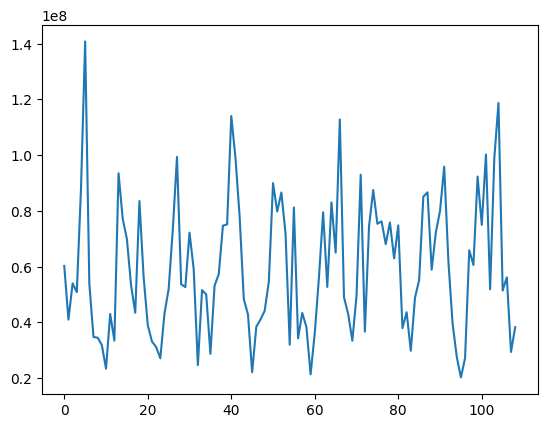

In [37]:
plt.figure(1)
plt.plot(all_losses)

In [38]:
np.mean(all_losses)

59416604.0

In [14]:
submission.head()

,margin
day,
2012-10-25,0.0
2012-10-26,152096928.0
2012-10-27,111819880.0
2012-10-28,167517216.0
2012-10-29,148568128.0
